# Python code for the Final Project

**Project Title: Analyzing Cause of Death in Midlife in the United States**

Group 6: Sanghyun Cho(corresponding author), Jonghwa Do, Hansol Woo

files needed = (`02760-0001-Data.sav`, `MIDUS_Core_MortalityCauseData_N2459_20230531.sav`, `NCHS_-_Leading_Causes_of_Death__United_States.csv`, `cb_2021_us_state_5m`)

## 1. Importing libraries

In [1]:
import pandas as pd
pd.set_option('display.precision', 3)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyreadstat       # necessary to read spss file(*.sav)
import geopandas
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mtick
import statsmodels.formula.api as smf

In some environment, it might be necessary to install pyreadstat (When we experimented with the Winstat, we had to do it). In that case, please simply run `pip install pyreadstat` before running the whole code and proceed.

## 2. Reading datasets

First, we would read data from two '*.sav' files; **main** for basic characteristics, and **mortality** for the cause of death.
We need the argument `convert_categoricals` to be False. It makes the categories a set of integers, rather than strings.
This step is necessary for integrating ICD-9 and ICD-10 causes of death. We will cover this later on.
We read the mortality data one more time, with `convert_categoricals` to be True, and keep the names for the causes of death.
They will be used in the x-axis of the graph.

In [2]:
core_main = pd.read_spss('02760-0001-Data.sav', convert_categoricals=False)
core_mortality = pd.read_spss('MIDUS_Core_MortalityCauseData_N2459_20230531.sav', convert_categoricals=False)

core_mortality_cat = pd.read_spss('MIDUS_Core_MortalityCauseData_N2459_20230531.sav', convert_categoricals=True)
core_mortality['UNDERCOD_C_name'] = core_mortality_cat['UNDERCOD_C']

In [3]:
core_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7108 entries, 0 to 7107
Columns: 2098 entries, M2ID to A1ST5
dtypes: float64(2098)
memory usage: 113.8 MB


There are a lot of columns that describe various characteristics of the sample.

We would later extract some of them, which are of research interest.

In [4]:
core_mortality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   M2ID               2459 non-null   float64 
 1   M2FAMNUM           2229 non-null   float64 
 2   SAMPLMAJ           2459 non-null   float64 
 3   B1PRSEX            2459 non-null   float64 
 4   DECEASED           2459 non-null   float64 
 5   DOD_M              2459 non-null   float64 
 6   DOD_Y              2459 non-null   float64 
 7   UNDERCOD_ICD9      132 non-null    object  
 8   UNDERCOD_ICD10     2234 non-null   object  
 9   NUM_MULTICOD       2459 non-null   float64 
 10  MULTICOD_1_ICD9    132 non-null    object  
 11  MULTICOD_1_ICD10   2234 non-null   object  
 12  MULTICOD_2_ICD9    94 non-null     object  
 13  MULTICOD_2_ICD10   1660 non-null   object  
 14  MULTICOD_3_ICD9    55 non-null     object  
 15  MULTICOD_3_ICD10   1146 non-null   object  
 16  MULTIC

We would change the type of M2ID from float to integer and set M2ID as index since there is no argument `index_col` in `pd.read_spss`.

In [5]:
core_main['M2ID'] = core_main['M2ID'].astype('int')
core_mortality['M2ID'] = core_mortality['M2ID'].astype('int')

core_main.set_index('M2ID', inplace=True)
core_mortality.set_index('M2ID', inplace=True)

core_mortality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2459 entries, 10002 to 19186
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   M2FAMNUM           2229 non-null   float64 
 1   SAMPLMAJ           2459 non-null   float64 
 2   B1PRSEX            2459 non-null   float64 
 3   DECEASED           2459 non-null   float64 
 4   DOD_M              2459 non-null   float64 
 5   DOD_Y              2459 non-null   float64 
 6   UNDERCOD_ICD9      132 non-null    object  
 7   UNDERCOD_ICD10     2234 non-null   object  
 8   NUM_MULTICOD       2459 non-null   float64 
 9   MULTICOD_1_ICD9    132 non-null    object  
 10  MULTICOD_1_ICD10   2234 non-null   object  
 11  MULTICOD_2_ICD9    94 non-null     object  
 12  MULTICOD_2_ICD10   1660 non-null   object  
 13  MULTICOD_3_ICD9    55 non-null     object  
 14  MULTICOD_3_ICD10   1146 non-null   object  
 15  MULTICOD_4_ICD9    27 non-null     object  
 16  MULTIC

In [6]:
core_main.sample(5)

,M2FAMNUM,SAMPLMAJ,A1STATUS,A1PAGE_M2,A1PRAGE_2019,M1AGE_FLAG,A1PBYEAR,A1PBYEAR_2019,M1BYEAR_FLAG,A1PRSEX,...,A1SS15_8,A1SS15_9,A1SS15_10,A1SS16,A1SS17,A1ST1,A1ST2,A1ST3,A1ST4,A1ST5
M2ID,,,,,,,,,,,,,,,,,,,,,
13061,101267.0,1.0,2.0,25.0,25.0,0.0,1969.0,1969.0,0.0,1.0,...,2.0,2.0,2.0,4.0,4.0,8.0,8.0,10.0,9.0,9.0
10415,100167.0,1.0,2.0,45.0,45.0,0.0,1950.0,1950.0,0.0,1.0,...,2.0,2.0,1.0,4.0,4.0,9.0,8.0,9.0,10.0,8.0
14257,120257.0,3.0,2.0,35.0,35.0,0.0,1960.0,1960.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,7.0,3.0,9.0,7.0,8.0
13153,101301.0,4.0,2.0,54.0,54.0,0.0,1940.0,1940.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,9.0,6.0,9.0,9.0,9.0
16693,110373.0,2.0,2.0,63.0,63.0,0.0,1932.0,1932.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,8.0,8.0,8.0


We would also read data from `NCHS_-_Leading_Causes_of_Death__United_States.csv`, which contains yearly causes of death for the whole population, divided by the states. We would use this data to compare it with MIDUS data so that we can figure out whether the MIDUS data is well sampled.

In [7]:
NCHS_COD = pd.read_csv('NCHS_-_Leading_Causes_of_Death__United_States.csv')
NCHS_COD.drop('113 Cause Name', axis=1, inplace=True)
NCHS_COD

,Year,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,Unintentional injuries,United States,169936,49.4
1,2017,Unintentional injuries,Alabama,2703,53.8
2,2017,Unintentional injuries,Alaska,436,63.7
3,2017,Unintentional injuries,Arizona,4184,56.2
4,2017,Unintentional injuries,Arkansas,1625,51.8
...,...,...,...,...,...
10863,1999,Kidney disease,Virginia,1035,16.9
10864,1999,Kidney disease,Washington,278,5.2
10865,1999,Kidney disease,West Virginia,345,16.4
10866,1999,Kidney disease,Wisconsin,677,11.9


We want to calculate the proportion of each cause of death since the dataset only contains the number of cases. We would unstack and stack the data so that we can calculate it for each year, and each state.

In [8]:
NCHS_COD = NCHS_COD.set_index(['Year', 'State', 'Cause Name'])
NCHS_COD = NCHS_COD.sort_index(ascending=True)

NCHS_COD_2 = NCHS_COD.drop('Age-adjusted Death Rate', axis=1)

NCHS_COD_2 = NCHS_COD_2.unstack('Cause Name')
NCHS_COD_2.columns = NCHS_COD_2.columns.droplevel(level = 0)

NCHS_COD_pct = NCHS_COD_2.copy()

for i in NCHS_COD_pct.columns.tolist():
    NCHS_COD_pct[i] = NCHS_COD_2[i] / NCHS_COD_2['All causes'] * 100

NCHS_COD_pct = NCHS_COD_pct.drop('All causes', axis=1)
NCHS_COD_pct['etc'] = 100 - NCHS_COD_pct.sum(axis=1)

NCHS_COD_pct

Cause Name          Alzheimer's disease   CLRD  Cancer  Diabetes  \
Year State                                                         
1999 Alabama                      1.723  4.863  21.216     2.993   
     Alaska                       0.886  5.391  23.375     2.474   
     Arizona                      2.404  6.375  22.487     2.654   
     Arkansas                     1.554  4.863  21.977     2.474   
     California                   1.976  5.739  23.135     2.791   
...                                 ...    ...     ...       ...   
2017 Virginia                     3.717  4.904  21.966     2.868   
     Washington                   6.509  5.574  22.219     3.179   
     West Virginia                3.308  7.222  19.995     3.712   
     Wisconsin                    4.609  5.380  21.484     2.720   
     Wyoming                      4.446  7.676  19.883     2.538   

Cause Name          Heart disease  Influenza and pneumonia  Kidney disease  \
Year State                                                                   
1999 Alabama               29.949                    2.741           2.185   
     Alaska                20.790                    1.699           1.256   
     Arizona               26.966                    3.213           1.358   
     Arkansas              29.776                    2.654           1.640   
     California            31.358                    1.988           0.986   
...                           ...                      ...             ...   
2017 Virginia              21.670                    1.815           2.359   
     Washington            20.321                    1.826           0.770   
     West Virginia         20.833                    1.968           1.873   
     Wisconsin             22.513                    1.849           1.750   
     Wyoming               20.994                    2.412           1.321   

Cause Name          Stroke  Suicide  Unintentional injuries     etc  
Year State                                                           
1999 Alabama         7.026    1.239                   5.162  20.903  
     Alaska          6.315    3.545                  10.857  23.412  
     Arizona         6.492    1.913                   5.528  20.609  
     Arkansas        8.075    1.203                   4.609  21.175  
     California      7.831    1.341                   4.010  18.845  
...                    ...      ...                     ...     ...  
2017 Virginia        5.184    1.719                   5.719  28.079  
     Washington      5.313    2.276                   6.062  25.950  
     West Virginia   4.545    1.688                   8.129  26.727  
     Wisconsin       4.770    1.758                   7.111  26.057  
     Wyoming         3.985    3.293                   7.299  26.154  

[988 rows x 11 columns]

## 3. Cleaning MIDUS data

First, we will simplify the **mortality** file.

There are three versions of COD in the **mortality** file:
1. one based on ICD-9(`UNDERCOD_ICD9`) for people who had passed away between 1979 and 1998,
2. another based on ICD-10(`UNDERCOD_ICD10`) for people who have deceased in 1999 and afterward,
3. the other based on 6 leading causes(`UNDERCOD_C`)

In the proposal, we showed the six leading causes of death in the U.S. in recent years, which are in `UNDERCOD_C`.
For the main project, one of the most important parts of our project is to merge `UNDERCOD_ICD9` and `UNDERCOD_ICD10` into consolidated causes of death.

There are data without any known causes of death(`NaN`) for `UNDERCOD_C`. We want to get rid of them.

In [9]:
core_mortality.dropna(subset='UNDERCOD_C', inplace=True)
core_mortality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2366 entries, 10002 to 19186
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   M2FAMNUM           2158 non-null   float64 
 1   SAMPLMAJ           2366 non-null   float64 
 2   B1PRSEX            2366 non-null   float64 
 3   DECEASED           2366 non-null   float64 
 4   DOD_M              2366 non-null   float64 
 5   DOD_Y              2366 non-null   float64 
 6   UNDERCOD_ICD9      132 non-null    object  
 7   UNDERCOD_ICD10     2234 non-null   object  
 8   NUM_MULTICOD       2366 non-null   float64 
 9   MULTICOD_1_ICD9    132 non-null    object  
 10  MULTICOD_1_ICD10   2234 non-null   object  
 11  MULTICOD_2_ICD9    94 non-null     object  
 12  MULTICOD_2_ICD10   1660 non-null   object  
 13  MULTICOD_3_ICD9    55 non-null     object  
 14  MULTICOD_3_ICD10   1146 non-null   object  
 15  MULTICOD_4_ICD9    27 non-null     object  
 16  MULTIC

93 observations(2,459 - 2,366) with `NaN` are deleted.

## 4. Merging two datasets

Now, We will merge two datasets on the index.
We will use **left** merge, with **mortality** on the left since we focus on the causes of death.

In [10]:
core_merge = pd.merge(left=core_mortality, right=core_main, left_index=True, right_index=True, how='left', indicator=True)
core_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2366 entries, 10002 to 19186
Columns: 2140 entries, M2FAMNUM_x to _merge
dtypes: category(2), float64(2117), object(21)
memory usage: 38.7+ MB


In [11]:
core_merge[core_merge['_merge'] == 'left_only'].count()

M2FAMNUM_x      0
SAMPLMAJ_x    208
B1PRSEX       208
DECEASED      208
DOD_M         208
             ... 
A1ST2           0
A1ST3           0
A1ST4           0
A1ST5           0
_merge        208
Length: 2140, dtype: int64

Now there are 208 observations without the respondents' characteristics. We will get rid of them.

In [12]:
core_merge = core_merge[core_merge['_merge'] != 'left_only']
core_merge.drop(columns=['_merge'], inplace=True)
core_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2158 entries, 10002 to 19186
Columns: 2139 entries, M2FAMNUM_x to A1ST5
dtypes: category(1), float64(2117), object(21)
memory usage: 35.2+ MB


## 5. Preparing for drawing graphs

We will draw time-series graphs indicating changes in the causes of death. 
Since the size of the data is relatively small for each year, we will divide it into 5-year, 10-year, and 15-year intervals so that we can shed a different light on the data.

In [13]:
core_merge['DOD_Y'] = core_merge['DOD_Y'].astype('int')

core_merge['DOD_Y5'] = core_merge['DOD_Y']
core_merge['DOD_Y10'] = core_merge['DOD_Y']
core_merge['DOD_Y15'] = core_merge['DOD_Y']

for i in range(1995, 2022, 5):
    core_merge.loc[(core_merge['DOD_Y'] >= i) & (core_merge['DOD_Y'] < i+5), 'DOD_Y5'] = str(i)+'-'+str(i+4)

for i in range(1995, 2022, 10):
    core_merge.loc[(core_merge['DOD_Y'] >= i) & (core_merge['DOD_Y'] < i+10), 'DOD_Y10'] = str(i)+'-'+str(i+9)

for i in range(1995, 2022, 15):
    core_merge.loc[(core_merge['DOD_Y'] >= i) & (core_merge['DOD_Y'] < i+15), 'DOD_Y15'] = str(i)+'-'+str(i+14)

core_merge.loc[core_merge['DOD_Y5'] == '2020-2024', 'DOD_Y5'] = '2020-2022'
core_merge.loc[core_merge['DOD_Y10'] == '2015-2024', 'DOD_Y10'] = '2015-2022'
core_merge.loc[core_merge['DOD_Y15'] == '2010-2024', 'DOD_Y15'] = '2010-2022'

C:\Users\stone\AppData\Local\Temp\ipykernel_27732\375912169.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1995-1999' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  core_merge.loc[(core_merge['DOD_Y'] >= i) & (core_merge['DOD_Y'] < i+5), 'DOD_Y5'] = str(i)+'-'+str(i+4)
C:\Users\stone\AppData\Local\Temp\ipykernel_27732\375912169.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1995-2004' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  core_merge.loc[(core_merge['DOD_Y'] >= i) & (core_merge['DOD_Y'] < i+10), 'DOD_Y10'] = str(i)+'-'+str(i+9)
C:\Users\stone\AppData\Local\Temp\ipykernel_27732\375912169.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1995-2009' has dtype incompatible 

## 6. Creating a new codeset for 27 causes of death

Now we will look deeper into the causes of death to extract the cases of 'death of despair.' The main step we will go through is to make a new column `UNDERCOD_SIM27`, which enumerates the 27 most frequent causes of death.

In [14]:
core_merge_9 = core_merge.sort_values(by='UNDERCOD_ICD9')

core_merge_9['UNDERCOD_ICD9'].unique()

array(['0420', '1175', '1179', '135', '1419', '1539', '1550', '1552',
       '1579', '1629', '1719', '1729', '1749', '1830', '185', '1919',
       '1991', '2028', '2030', '2051', '2500', '2501', '2773', '2898',
       '3320', '4029', '4049', '410', '4140', '4148', '4149', '4151',
       '4240', '4249', '4254', '4274', '4280', '4289', '431', '4331',
       '436', '4439', '486', '4919', '492', '4939', '496', '512', '5609',
       '5699', '5715', '5733', '5839', '7425', '7999', 'E8121', 'E8159',
       'E888', 'E9289', 'E9585', 'E963', nan], dtype=object)

In [15]:
UNDERCOD_ICD9_dict = {'0420' : 21, '1175' : 27, '1179' : 27, '135' : 27, '1419' : 1, '1539' : 1,
                      '1550' : 1, '1552' : 1, '1579' : 1, '1629' : 1, '1719' : 1, '1729' : 1,
                      '1749' : 1, '1830' : 1, '185' : 1, '1919' : 1, '1991' : 1, '2028' : 1,
                      '2030' : 1, '2051' : 1, '2500' : 6, '2501' : 6, '2773' : 27, '2898' : 27,
                      '3320' : 11, '4029' : 2, '4049' : 2, '410' : 2, '4140' : 2, '4148' : 2, '4149' : 2,
                      '4151' : 2, '4240' : 2, '4249' : 2, '4254' : 2, '4274' : 2, '4280' : 2, '4289' : 2,
                      '431' : 4, '4331' : 4, '436' : 4, '4439' : 27, '486' : 8, '4919' : 3, '492' : 3,
                      '4939' : 3, '496' : 3, '512' : 27, '5609' : 27, '5699' : 27, '5715' : 14, '5733' : 27,
                      '5839' : 9, '7425' : 23, '7999' : 27, 'E8121' : 7, 'E8159' : 7, 'E888' : 7,
                      'E9289' : 7, 'E9585' : 16, 'E963' : 19}

In [16]:
core_merge['UNDERCOD_SIM27'] = core_merge['UNDERCOD_ICD9'].replace(UNDERCOD_ICD9_dict)

core_merge_27 = core_merge.sort_values(by='UNDERCOD_SIM27')

core_merge_27['UNDERCOD_SIM27'].unique()

array([ 1.,  2.,  3.,  4.,  6.,  7.,  8.,  9., 11., 14., 16., 19., 21.,
       23., 27., nan])

In [17]:
core_merge_10 = core_merge.sort_values(by='UNDERCOD_ICD10')

core_merge_10['UNDERCOD_ICD10'].unique()

array(['A047', 'A084', 'A099', 'A415', 'A419', 'A490', 'A499', 'B182',
       'B199', 'B208', 'B238', 'B24', 'B342', 'B91', 'C01', 'C029',
       'C069', 'C07', 'C109', 'C119', 'C140', 'C159', 'C160', 'C169',
       'C181', 'C187', 'C189', 'C19', 'C20', 'C220', 'C221', 'C229',
       'C240', 'C253', 'C259', 'C269', 'C319', 'C329', 'C349', 'C37',
       'C383', 'C399', 'C419', 'C437', 'C439', 'C444', 'C446', 'C449',
       'C459', 'C482', 'C491', 'C494', 'C499', 'C509', 'C519', 'C541',
       'C55', 'C56', 'C579', 'C61', 'C64', 'C66', 'C679', 'C712', 'C716',
       'C719', 'C73', 'C780', 'C798', 'C80', 'C830', 'C833', 'C841',
       'C850', 'C851', 'C859', 'C900', 'C910', 'C911', 'C920', 'C921',
       'C925', 'C950', 'C959', 'C97', 'D429', 'D432', 'D469', 'D471',
       'D472', 'D619', 'D649', 'D689', 'D70', 'D752', 'E039', 'E105',
       'E107', 'E109', 'E111', 'E112', 'E115', 'E117', 'E119', 'E141',
       'E142', 'E144', 'E145', 'E146', 'E147', 'E149', 'E162', 'E271',
       'E43', 

Wow, there are a lot of keys to assign. To make our lives simpler, we would use `dict.update` function
with `dict.fromkeys` argument to assign the same values (which are SIM27 codes) to multiple keys (which are ICD-10 codes).

We referred to *https://stackoverflow.com/questions/2974022/is-it-possible-to-assign-the-same-value-to-multiple-keys-in-a-dict-object-at-onc* for this function and the argument.

In [18]:
UNDERCOD_ICD10_dict = {}

UNDERCOD_ICD10_dict.update(dict.fromkeys(['C01', 'C029', 'C069', 'C07', 'C109', 'C119', 'C140',
                                          'C159', 'C160', 'C169', 'C181', 'C187', 'C189', 'C19',
                                          'C20', 'C220', 'C221', 'C229', 'C240', 'C253', 'C259',
                                          'C269', 'C319', 'C329', 'C349', 'C37', 'C383', 'C399',
                                          'C419', 'C437', 'C439', 'C444', 'C446', 'C449', 'C459',
                                          'C482', 'C491', 'C494', 'C499', 'C509', 'C519', 'C541',
                                          'C55', 'C56', 'C579', 'C61', 'C64', 'C66', 'C679', 'C712', 'C716',
                                          'C719', 'C73', 'C780', 'C798', 'C80', 'C830', 'C833', 'C841',
                                          'C850', 'C851', 'C859', 'C900', 'C910', 'C911', 'C920', 'C921',
                                          'C925', 'C950', 'C959', 'C97'], 1))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['I080', 'I082', 'I099', 'I110', 'I119', 'I131', 'I139', 'I214',
                                          'I219', 'I248', 'I249', 'I250', 'I251', 'I255', 'I258', 'I259',
                                          'I269', 'I272', 'I312', 'I313', 'I340', 'I350', 'I359', 'I361',
                                          'I38', 'I420', 'I425', 'I429', 'I442', 'I461', 'I469', 'I48',
                                          'I490', 'I499', 'I500', 'I509', 'I516', 'I519'], 2))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['J42', 'J439', 'J440', 'J441', 'J448', 'J449'], 3))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['I607', 'I609', 'I610', 'I613', 'I614', 'I615', 'I619',
                                          'I620', 'I629', 'I632', 'I633', 'I634', 'I639', 'I64',
                                          'I671', 'I672', 'I678', 'I679', 'I691', 'I694', 'I698'], 4))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['G301', 'G309'], 5))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['E105', 'E107', 'E109', 'E111', 'E112', 'E115', 'E117', 'E119', 'E141',
                                          'E142', 'E144', 'E145', 'E146', 'E147', 'E149'], 6))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['V031', 'V194', 'V234', 'V274', 'V295', 'V445', 'V535', 'V584', 'V594',
                                          'V599', 'V800', 'V877', 'V892', 'W06', 'W10', 'W18', 'W19', 'W40',
                                          'W70', 'W79', 'W80', 'X00', 'X01', 'X31', 'X47', 'X59', 'X590', 'X599', 'Y86'], 7))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['J100', 'J101', 'J110', 'J150', 'J152', 'J159', 'J181', 'J189'], 8))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['N049', 'N179', 'N180', 'N185', 'N189', 'N19', 'N288'], 9))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['A415', 'A419'], 10))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['G20'], 11))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['F191', 'X42', 'X44', 'Y14'], 12))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['I10', 'I120'], 13))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['K743', 'K746'], 14))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['U071'], 15))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['X62', 'X65', 'X67', 'X69', 'X72', 'X74'], 16))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['F101', 'F102', 'K703', ], 17))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['I711', 'I712', 'I713', 'I714'], 18))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['X94', 'X95', 'Y02', 'Y08'], 19))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['K802', 'K805', 'K810', 'K819'], 20))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['B208', 'B238', 'B24'], 21))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['Y484', 'Y608', 'Y834', 'Y839', 'Y848'], 22))

UNDERCOD_ICD10_dict.update(dict.fromkeys([], 23))

UNDERCOD_ICD10_dict.update(dict.fromkeys([], 24))

UNDERCOD_ICD10_dict.update(dict.fromkeys([], 25))

UNDERCOD_ICD10_dict.update(dict.fromkeys([], 26))

UNDERCOD_ICD10_dict.update(dict.fromkeys(['A047', 'A084', 'A099', 'A490', 'A499', 'B182', 'B199', 'B342', 'B91', 
                                          'D429', 'D432', 'D469', 'D471', 'D472', 'D619', 'D649', 'D689', 'D70', 'D752',
                                          'E039', 'E162', 'E271', 'E43', 'E45', 'E46', 'E668', 'E669', 'E780', 'E785',
                                          'E854', 'E859', 'E86', 'F019', 'F03', 'F059', 'F069', 'F339', 'G10', 'G122',
                                          'G310', 'G311', 'G318', 'G319', 'G409', 'G510', 'G700', 'G710', 'G808',
                                          'G903', 'G909', 'G919', 'G92', 'G931', 'G934', 'I709', 'I739', 'I776', 'I802',
                                          'J61', 'J690', 'J82', 'J841', 'J849', 'J90', 'J961', 'J984', 'J988', 'J989',
                                          'K210', 'K222', 'K225', 'K274', 'K315', 'K358', 'K449', 'K519', 'K550',
                                          'K559', 'K566', 'K578', 'K579', 'K631', 'K638', 'K661', 'K729', 'K760',
                                          'K769', 'K830', 'K861', 'K922', 'M348', 'M625', 'M726', 'M793', 'M869', 
                                          'N135', 'N390', 'R02', 'R068', 'R092', 'R54', 'R568', 'R628', 'R688', 'R99',
                                          'Y34'], 27))

In [19]:
core_merge.loc[np.isnan(core_merge['UNDERCOD_SIM27']), 'UNDERCOD_SIM27'] = core_merge['UNDERCOD_ICD10'].replace(UNDERCOD_ICD10_dict)

core_merge_27 = core_merge.sort_values(by='UNDERCOD_SIM27')

core_merge_27['UNDERCOD_SIM27'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 27.])

In [20]:
underCOD_27 = core_merge_27['UNDERCOD_SIM27'].value_counts().to_frame()

if list(underCOD_27.columns)[0] == 'UNDERCOD_SIM27':
    underCOD_27.rename(columns={'UNDERCOD_SIM27':'count'}, inplace=True)

underCOD_27 = underCOD_27.sort_index()
underCOD_27['ratio'] = underCOD_27['count'].copy()

for i in underCOD_27.index.tolist():
    underCOD_27.loc[i,'ratio'] = underCOD_27.loc[i,'count'] / underCOD_27['count'].sum() * 100
    
underCOD_27.to_csv('underCOD_27.csv')
underCOD_27

C:\Users\stone\AppData\Local\Temp\ipykernel_27732\1248158114.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '26.7840593141798' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  underCOD_27.loc[i,'ratio'] = underCOD_27.loc[i,'count'] / underCOD_27['count'].sum() * 100


,count,ratio
UNDERCOD_SIM27,,
1.0,578,26.784
2.0,520,24.096
3.0,165,7.646
4.0,120,5.561
5.0,72,3.336
6.0,69,3.197
7.0,70,3.244
8.0,34,1.576
9.0,28,1.297


Also, since we want to show how the proportion of causes of death changes across time, we will group and sort the data by the year.
We would use `pd.crosstab` function to calculate the number of deaths for each cause.

We referred to *https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b* for the function and the graph below.

We would also calculate the number and the proportion of deaths for each cause. We include the argument `normalize`.

In [21]:
DOD_Y15 = pd.crosstab(index=core_merge['DOD_Y15'],
                  columns=core_merge['UNDERCOD_SIM27'],
                  normalize="index")
DOD_Y15 = DOD_Y15*100
DOD_Y15 = DOD_Y15.T
DOD_Y15['diff'] = DOD_Y15['2010-2022'] - DOD_Y15['1995-2009']
DOD_Y15.sort_values(by = 'diff', ascending=False, inplace=True)
DOD_Y15

DOD_Y15,1995-2009,2010-2022,diff
UNDERCOD_SIM27,,,
27.0,10.673,16.703,6.030
5.0,1.017,4.668,3.652
15.0,0.000,2.918,2.918
4.0,4.701,6.054,1.353
11.0,0.381,1.678,1.296
9.0,0.889,1.532,0.642
22.0,0.000,0.365,0.365
20.0,0.127,0.292,0.165
8.0,1.525,1.605,0.080


For the analysis of the death of despair, we need to expand the data to the multiple causes of death. Since we are only interested in the decedents who are classified as dead of despair for multiple causes of death, we will collect all ICD codes related to the death of despair and assign values for 27 causes of death.

In [22]:
multiCOD_ICD9_list = []
multiCOD_ICD10_list = []

for i in range(1,8):
    multiCOD_ICD9_list.extend(core_merge['MULTICOD_'+str(i)+'_ICD9'].dropna().tolist())

for i in range(1,13):
    multiCOD_ICD10_list.extend(core_merge['MULTICOD_'+str(i)+'_ICD10'].dropna().tolist())

multiCOD_ICD9_list = list(set(multiCOD_ICD9_list))
multiCOD_ICD10_list = list(set(multiCOD_ICD10_list))

multiCOD_ICD9_list.sort()
multiCOD_ICD10_list.sort()

multiCOD_df9 = pd.DataFrame(multiCOD_ICD9_list)
multiCOD_df10 = pd.DataFrame(multiCOD_ICD10_list)

multiCOD_df9.to_csv('multiCOD_df9.csv')
multiCOD_df10.to_csv('multiCOD_df10.csv')

In [23]:
multiCOD_ICD9_dict = UNDERCOD_ICD9_dict.copy()

multiCOD_ICD9_dict = {key:val for key, val in multiCOD_ICD9_dict.items() if (val == 12) | (val == 16) | (val == 17)}

multiCOD_ICD9_dict.update(dict.fromkeys(['E9585'], 16))
multiCOD_ICD9_dict.update(dict.fromkeys(['303'], 17))

multiCOD_ICD10_dict = UNDERCOD_ICD10_dict.copy()

multiCOD_ICD10_dict = {key:val for key, val in multiCOD_ICD10_dict.items() if (val == 12) | (val == 16) | (val == 17)}

multiCOD_ICD10_dict.update(dict.fromkeys(['F112', 'F119', 'F141', 'F159', 'F179', 'F191', 'X42', 'X44', 'Y14'], 12))
multiCOD_ICD10_dict.update(dict.fromkeys(['X61', 'X62', 'X65', 'X67', 'X69', 'X72', 'X74'], 16))
multiCOD_ICD10_dict.update(dict.fromkeys(['F100', 'F101', 'F102', 'F109', 'K701', 'K703', 'K709', 'K852', 'X45'], 17))

core_merge['MULTICOD_SIM27'] = np.nan

core_merge.loc[core_merge['UNDERCOD_ICD9'].isin(multiCOD_ICD9_dict.keys()), 'MULTICOD_SIM27']= core_merge['UNDERCOD_ICD9'].replace(multiCOD_ICD9_dict)
core_merge.loc[core_merge['UNDERCOD_ICD10'].isin(multiCOD_ICD10_dict.keys()), 'MULTICOD_SIM27']= core_merge['UNDERCOD_ICD10'].replace(multiCOD_ICD10_dict)

for i in range(1,8):
    core_merge.loc[core_merge['MULTICOD_'+str(i)+'_ICD9'].isin(multiCOD_ICD9_dict.keys()), 'MULTICOD_SIM27']= core_merge['MULTICOD_'+str(i)+'_ICD9'].replace(multiCOD_ICD9_dict)

for i in range(1,13):
    core_merge.loc[core_merge['MULTICOD_'+str(i)+'_ICD10'].isin(multiCOD_ICD10_dict.keys()), 'MULTICOD_SIM27']= core_merge['MULTICOD_'+str(i)+'_ICD10'].replace(multiCOD_ICD10_dict)

C:\Users\stone\AppData\Local\Temp\ipykernel_27732\3014159255.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  core_merge.loc[core_merge['UNDERCOD_ICD9'].isin(multiCOD_ICD9_dict.keys()), 'MULTICOD_SIM27']= core_merge['UNDERCOD_ICD9'].replace(multiCOD_ICD9_dict)


In [24]:
multiCOD_27 = core_merge['MULTICOD_SIM27'].value_counts().to_frame()
multiCOD_27 = multiCOD_27.sort_index()

multiCOD_27

,count
MULTICOD_SIM27,
12,230
16,14
17,20


We can see that the number of deaths of despair, especially from drug-induced death, increases a lot. We would use this sample for further analysis.

## 7. Cleaning NCHS data

In [25]:
NCHS_COD_pct.xs('United States', level=1)

Cause Name,Alzheimer's disease,CLRD,Cancer,Diabetes,Heart disease,Influenza and pneumonia,Kidney disease,Stroke,Suicide,Unintentional injuries,etc
Year,,,,,,,,,,,
1999,1.862,5.193,22.992,2.860,30.325,2.665,1.486,6.999,1.221,4.092,20.305
2000,2.062,5.077,23.013,2.884,29.574,2.718,1.550,6.976,1.221,4.073,20.852
2001,2.229,5.091,22.917,2.954,28.974,2.567,1.634,6.768,1.267,4.202,21.398
2002,2.409,5.108,22.807,2.998,28.524,2.688,1.677,6.658,1.296,4.369,21.467
2003,2.592,5.162,22.747,3.031,27.982,2.662,1.734,6.441,1.286,4.463,21.900
2004,2.751,5.088,23.102,3.050,27.214,2.488,1.772,6.259,1.353,4.672,22.251
2005,2.925,5.349,22.848,3.069,26.638,2.574,1.793,5.865,1.333,4.812,22.795
2006,2.985,5.135,23.076,2.986,26.033,2.322,1.869,5.651,1.372,5.012,23.558
2007,3.079,5.278,23.224,2.945,25.418,2.175,1.916,5.609,1.427,5.104,23.823


In [26]:
NCHS_COD_pct_us = NCHS_COD_pct.xs('United States', level=1)
NCHS_COD_pct_us = NCHS_COD_pct_us.T
NCHS_COD_pct_us = NCHS_COD_pct_us.sort_values(by=1999, ascending=False)
NCHS_COD_pct_us = NCHS_COD_pct_us.T
NCHS_COD_pct_us = NCHS_COD_pct_us.sort_index(ascending=False)
NCHS_COD_pct_us['ETC'] = NCHS_COD_pct_us['etc']
NCHS_COD_pct_us = NCHS_COD_pct_us.drop('etc', axis=1)

NCHS_COD_pct_us_dec2 = NCHS_COD_pct_us[['Cancer', 'Heart disease']]
NCHS_COD_pct_us_inc2 = NCHS_COD_pct_us[["Alzheimer's disease", 'Suicide']]

DOD_Y5 = pd.crosstab(index=core_merge['DOD_Y5'],
                  columns=core_merge['UNDERCOD_SIM27'],
                  normalize="index")
DOD_Y5 = DOD_Y5*100
DOD_Y5 = DOD_Y5.sort_index(ascending=False)
DOD_Y5 = DOD_Y5[[2,1,4,3,7,6,8,5,9,16]]
DOD_Y5['ETC'] = 100 - DOD_Y5.sum(axis=1)

## 8. Identifying descriptive statistics

To figure out the average characteristics of both the entire sample and the deceased from despair, we should first make dummy variables that identify race, education level, marital status, and sex. We would use age and household income as the original dataset provides.

In [27]:
for i in core_merge.index.tolist():
    if core_merge.loc[i, 'A1SS7'] == 1: # race: 1 for white, 2-6 for non-white
        core_merge.loc[i, 'white'] = 1
    else:
        core_merge.loc[i, 'white'] = 0

for i in core_merge.index.tolist():
    if core_merge.loc[i, 'A1PB1'] < 8: # degree: 1-7 for no college degree, 8-12 for college degree or above
        core_merge.loc[i, 'edu'] = 0
    else:
        core_merge.loc[i, 'edu'] = 1

for i in core_merge.index.tolist():
    if core_merge.loc[i, 'A1PB17'] == 1: # marital status: 1 for married, 2-5 for non-married
        core_merge.loc[i, 'married'] = 1
    else:
        core_merge.loc[i, 'married'] = 0
        
core_merge['age'] = core_merge['A1PAGE_M2'] # age

for i in core_merge.index.tolist():
    if core_merge.loc[i, 'A1PRSEX'] == 1: # sex: 1 for male, 2 for female
        core_merge.loc[i, 'sex'] = 1
    else:
        core_merge.loc[i, 'sex'] = 0
        
core_merge['income'] = core_merge['A1SHHTOT'] # HH income

for i in core_merge.index.tolist():
    if (core_merge.loc[i, 'MULTICOD_SIM27'] == 12) | (core_merge.loc[i, 'MULTICOD_SIM27'] == 16) | (core_merge.loc[i, 'MULTICOD_SIM27'] == 17):
        core_merge.loc[i, 'DOD_D'] = 1
    else:
        core_merge.loc[i, 'DOD_D'] = 0

core_merge['income2'] = core_merge['income'] / 100000

In [28]:
core_merge[['DOD_D','white','edu','married','age','sex','income']].dropna().describe()

,DOD_D,white,edu,married,age,sex,income
count,1859.000,1859.000,1859.000,1859.000,1859.000,1859.000,1859.000
mean,0.118,0.907,0.299,0.652,58.192,0.521,58489.779
std,0.322,0.290,0.458,0.476,10.810,0.500,57903.463
min,0.000,0.000,0.000,0.000,25.000,0.000,0.000
25%,0.000,1.000,0.000,0.000,51.000,0.000,21750.000
50%,0.000,1.000,0.000,1.000,60.000,1.000,42000.000
75%,0.000,1.000,1.000,1.000,67.000,1.000,74000.000
max,1.000,1.000,1.000,1.000,75.000,1.000,300000.000


Above is the descriptive statistics for the whole sample after dropping observations with no income reported.

In [29]:
core_merge.loc[core_merge['DOD_D'] == 1, ['DOD_D','white','edu','married','age','sex','income']].describe()

,DOD_D,white,edu,married,age,sex,income
count,264.0,264.000,264.000,264.000,258.000,264.000,219.000
mean,1.0,0.758,0.189,0.545,51.624,0.598,64796.804
std,0.0,0.429,0.393,0.499,11.546,0.491,63219.191
min,1.0,0.000,0.000,0.000,25.000,0.000,0.000
25%,1.0,1.000,0.000,0.000,44.000,0.000,22750.000
50%,1.0,1.000,0.000,1.000,52.500,1.000,44000.000
75%,1.0,1.000,0.000,1.000,61.000,1.000,81000.000
max,1.0,1.000,1.000,1.000,73.000,1.000,300000.000


Above is the descriptive statistics for the decedents related to the death of despair.

## 9. Running regressions

We would run OLS, Logit and Probit models for robustness.

In [30]:
core_merge_reg = core_merge[['DOD_D','white','edu','married','age','sex','income','income2']].dropna()

DOD_ols = smf.ols('DOD_D ~ white + edu + married + age + sex + income2', data=core_merge_reg).fit()
print(DOD_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  DOD_D   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     13.63
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           3.41e-15
Time:                        23:19:44   Log-Likelihood:                -493.20
No. Observations:                1859   AIC:                             1000.
Df Residuals:                    1852   BIC:                             1039.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4068      0.047      8.742      0.0

In [31]:
DOD_logit = smf.logit('DOD_D ~ white + edu + married + age + sex + income2', data=core_merge_reg).fit()
print(DOD_logit.summary())

Optimization terminated successfully.
         Current function value: 0.341827
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  DOD_D   No. Observations:                 1859
Model:                          Logit   Df Residuals:                     1852
Method:                           MLE   Df Model:                            6
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                 0.05711
Time:                        23:19:44   Log-Likelihood:                -635.46
converged:                       True   LL-Null:                       -673.94
Covariance Type:            nonrobust   LLR p-value:                 1.506e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4600      0.420      1.094      0.274      -0.364       1.284
white          0.2967      0.

In [32]:
DOD_probit = smf.probit('DOD_D ~ white + edu + married + age + sex + income2', data=core_merge_reg).fit()
print(DOD_probit.summary())

Optimization terminated successfully.
         Current function value: 0.341251
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                  DOD_D   No. Observations:                 1859
Model:                         Probit   Df Residuals:                     1852
Method:                           MLE   Df Model:                            6
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                 0.05869
Time:                        23:19:44   Log-Likelihood:                -634.39
converged:                       True   LL-Null:                       -673.94
Covariance Type:            nonrobust   LLR p-value:                 5.449e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1751      0.232      0.756      0.450      -0.279       0.629
white          0.1767      0.

# Figures included in the Paper

## Figure 1

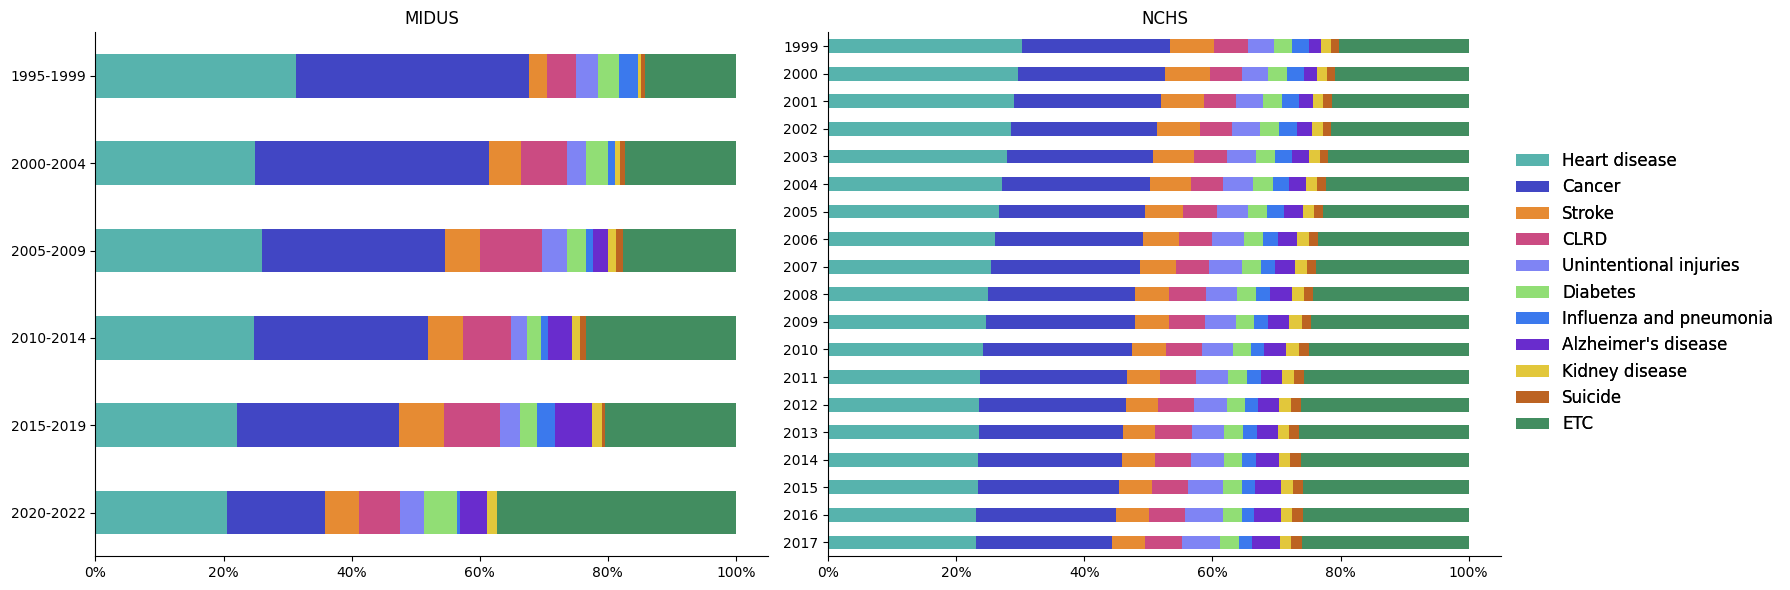

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
colors = ['#57B3AD', '#4146C4', '#E68B33', '#CB4B82', '#7F84F4', '#91DE75', '#3B79ED', '#692CCD', '#E2C73B', '#BC6322', '#428D60']

# plot
DOD_Y5.plot(kind='barh', stacked=True, ax=ax[0], color = colors)
NCHS_COD_pct_us.plot(kind='barh', stacked=True, ax=ax[1], color = colors)

ax[0].legend().set_visible(False)
legend = ax[1].legend(loc='upper left', bbox_to_anchor=(1, 0.8), frameon=False, fontsize='large', ncol=1)
fig.add_artist(legend)

ax[0].set_title("MIDUS", fontsize='large')
ax[1].set_title("NCHS", fontsize='large')

for i in range(0,2):
    ax[i].set_xlabel('')
    ax[i].xaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylabel('')

plt.tight_layout()
plt.savefig('fig1.pdf')
plt.show()

## Figure 2

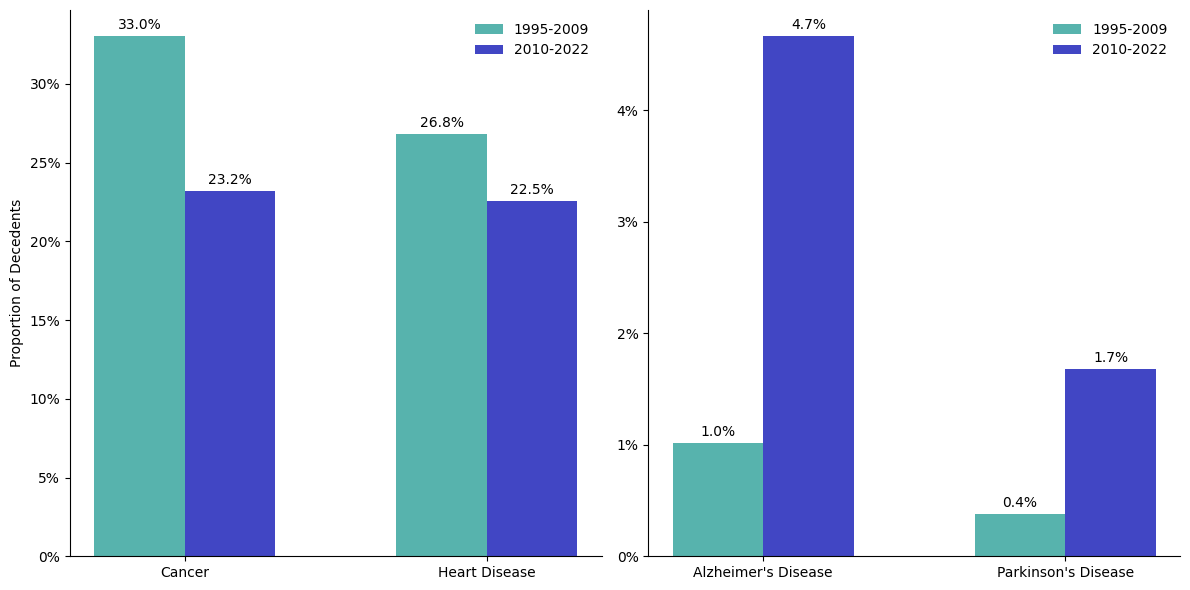

In [34]:
DOD_Y15_dec2 = DOD_Y15.loc[[1,2],:]
DOD_Y15_inc2 = DOD_Y15.loc[[5,11],:]

fig, ax = plt.subplots(1, 2, figsize=(12,6)) 

X_axis = np.arange(len(DOD_Y15_inc2))  

color1 = "#57B3AD"
color2 = "#4146C4"

ax[0].bar(X_axis - 0.15, DOD_Y15_dec2['1995-2009'], 0.3, label='1995-2009', color=color1)
ax[0].bar(X_axis + 0.15, DOD_Y15_dec2['2010-2022'], 0.3, label='2010-2022', color=color2)

ax[1].bar(X_axis - 0.15, DOD_Y15_inc2['1995-2009'], 0.3, label='1995-2009', color=color1)
ax[1].bar(X_axis + 0.15, DOD_Y15_inc2['2010-2022'], 0.3, label='2010-2022', color=color2)
 
ax[0].set_ylabel("Proportion of Decedents")
ax[1].set_ylabel("")

for axis in ax:
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))  
    axis.set_xticks(X_axis)
    axis.legend(frameon=False)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

ax[0].set_xticklabels(["Cancer","Heart Disease"])  
ax[1].set_xticklabels(["Alzheimer's Disease", "Parkinson's Disease"])  

for axis in ax:
    for bar in axis.patches:
        height = bar.get_height()
        axis.annotate(f'{height:.1f}%',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom')

plt.tight_layout()
plt.savefig('fig2.pdf')
plt.show()

## Figure 3

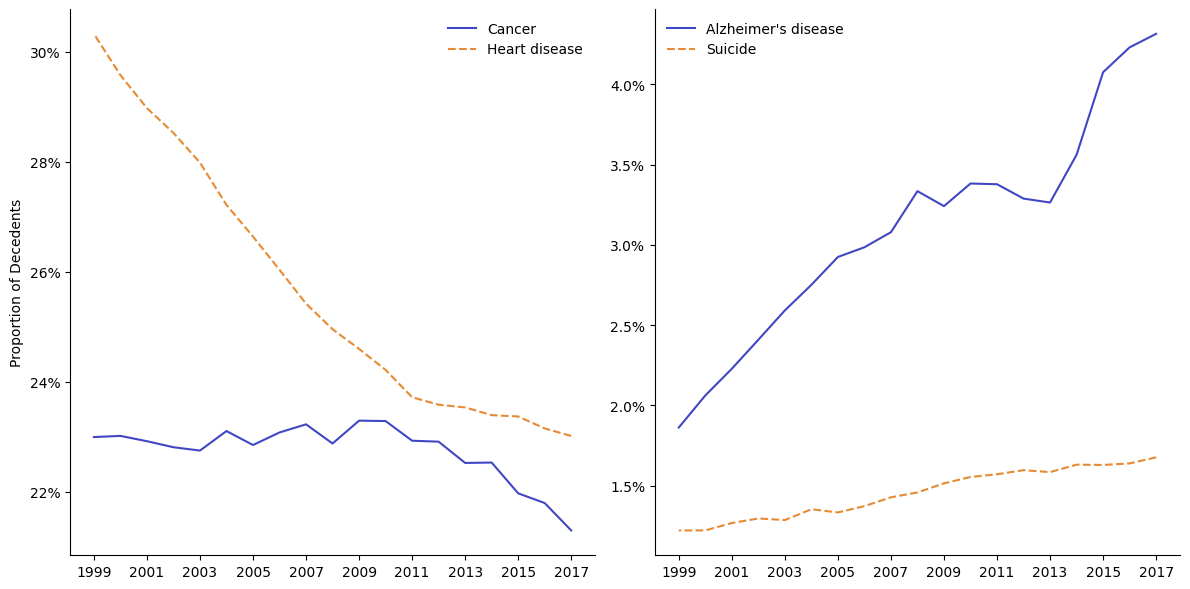

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12,6)) 
colors = ['#4146C4', '#E68B33']

# First Graph
NCHS_COD_pct_us_dec2["Cancer"].plot(ax=ax[0], color = colors[0])
NCHS_COD_pct_us_dec2["Heart disease"].plot(ax=ax[0], color = colors[1], linestyle="--")
ax[0].set_ylabel("Proportion of Decedents")  
ax[0].set_xlabel("")  

# Second Graph
NCHS_COD_pct_us_inc2["Alzheimer's disease"].plot(ax=ax[1], color = colors[0])
NCHS_COD_pct_us_inc2["Suicide"].plot(ax=ax[1], color = colors[1], linestyle="--")
ax[1].set_ylabel("")
ax[1].set_xlabel("") 

for axis in ax:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    ticks = [year for year in range(1999, 2018, 2)]
    axis.set_xticks(ticks) # set ticks
    legend = axis.legend(frameon=False)
    legend.get_frame().set_linewidth(0.0)

ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))

plt.tight_layout()  
plt.savefig('fig3.pdf')
plt.show()

## Figure 4

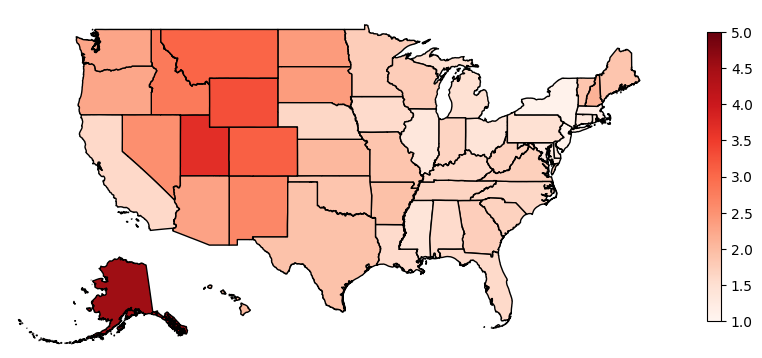

In [36]:
NCHS_COD_pct_suicide = NCHS_COD_pct.xs(2017, level=0)
NCHS_COD_pct_suicide = NCHS_COD_pct_suicide.sort_values(by='Suicide', ascending=False)
NCHS_COD_pct_suicide = NCHS_COD_pct_suicide.loc[:,'Suicide']
NCHS_COD_pct_suicide

states = geopandas.read_file('cb_2021_us_state_5m/cb_2021_us_state_5m.shp')

states_merge = pd.merge(left=states, right=NCHS_COD_pct_suicide,
                      left_on=['NAME'], right_index=True,
                      how='inner', indicator=True)

others = ['HI', 'VI', 'PR', 'AS', 'MP', 'GU', 'AK']

lower_48 = states_merge[~states_merge['STUSPS'].isin(others)]
ak = states_merge[states_merge['STUSPS']=='AK']
hi = states_merge[states_merge['STUSPS']=='HI']

fig, gax = plt.subplots(figsize=(10,15))
plt.axis('off')
lower_48.plot(ax = gax, edgecolor='black', column='Suicide', legend=True, cmap='Reds', legend_kwds={'shrink': 0.25},
              vmin=1, vmax=5)

# Plotting Alaska
ak2 = ak.to_crs('EPSG:8806')

axins1 = inset_axes(gax, width='100%', height='100%',
                    bbox_to_anchor=(-.05, 0, 0.3, 0.3),
                    bbox_transform=gax.transAxes)

ak2.plot(ax=axins1, edgecolor='black', column='Suicide', cmap='Reds', vmin=1, vmax=5)
plt.axis('off')

# Plotting Hawaii  
axins2 = inset_axes(gax,width='100%', height='100%',  
                    bbox_to_anchor=(.25, .1, 0.1, 0.1),
                    bbox_transform=gax.transAxes)

hi.plot(ax=axins2, edgecolor='black', column='Suicide', cmap='Reds', vmin=1, vmax=5)
plt.axis('off')

plt.savefig('fig4.png')
plt.show()